### Task 1 - Data Loading and data Preparation

In [1]:
#Read data by pandas library
import pandas as pd
X_train = pd.read_csv('x_train.csv', header=None)
y_train =pd.read_csv('y_train.csv', header=None)
X_test = pd.read_csv('x_test.csv', header=None)
y_test = pd.read_csv('y_test.csv', header=None)


# check for null values
null_values_X_train = X_train.isnull()
null_values_y_train = y_train.isnull()
null_values_X_test = X_test.isnull()
null_values_y_test = y_test.isnull()
print(null_values_X_train)
print(null_values_y_train)
print(null_values_X_test)
print(null_values_y_test)

# select rows that contain the substring '#NAME?' in any column of the X_train DataFrame
X_train[X_train.apply(lambda row: row.astype(str).str.contains('#NAME?', na=False).any(), axis=1)]

# select rows that contain the substring '#NAME?' in any column of the y_train DataFrame
y_train[y_train.apply(lambda row: row.astype(str).str.contains('#NAME?', na=False).any(), axis=1)]

# select rows that contain the substring '#NAME?' in any column of the X_test DataFrame
X_test[X_test.apply(lambda row: row.astype(str).str.contains('#NAME?', na=False).any(), axis=1)]

# select rows that contain the substring '#NAME?' in any column of the X_test DataFrame
y_test[y_test.apply(lambda row: row.astype(str).str.contains('#NAME?', na=False).any(), axis=1)]

# Merge the datasets horizontally
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

print(X_train.shape)
print(y_train.shape)
X_train

          0      1
0     False  False
1     False  False
2     False  False
3     False  False
4     False  False
...     ...    ...
2395  False  False
2396  False  False
2397  False  False
2398  False  False
2399  False  False

[2400 rows x 2 columns]
          0
0     False
1     False
2     False
3     False
4     False
...     ...
2395  False
2396  False
2397  False
2398  False
2399  False

[2400 rows x 1 columns]
         0      1
0    False  False
1    False  False
2    False  False
3    False  False
4    False  False
..     ...    ...
595  False  False
596  False  False
597  False  False
598  False  False
599  False  False

[600 rows x 2 columns]
         0
0    False
1    False
2    False
3    False
4    False
..     ...
595  False
596  False
597  False
598  False
599  False

[600 rows x 1 columns]
(2400, 2)
(2400, 1)


,0,1
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...
...,...,...
2395,yelp,The sweet potato fries were very good and seas...
2396,yelp,I could eat their bruschetta all day it is dev...
2397,yelp,Ambience is perfect.
2398,yelp,We ordered the duck rare and it was pink and t...


### Task 2 - Feature Representation

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from textblob import TextBlob

# download necessary stopwords and stemmer
nltk.download("stopwords")
stemmer = SnowballStemmer("english")

def preprocess_text(text):
    # remove non-alphabetic characters
    text = re.sub("[^a-zA-Z]", " ", text)

    # convert to lowercase
    text = text.lower()

    # correct spelling errors
    text = str(TextBlob(text).correct())

    # remove stopwords and perform stemming
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in set(stopwords.words("english"))]
    text = " ".join(words)

    return text

# apply preprocess function on the second column
X_train = X_train[1].apply(preprocess_text)
X_test = X_test[1].apply(preprocess_text)

from sklearn.model_selection import train_test_split
# split X_train into a 90% training set and a 10% validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# define the bag-of-words feature representation
vectorizer = CountVectorizer(min_df=1)

# fit the vectorizer to the datasets and transform the datasets
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)


# get the vocabulary size
vocab_size = len(vectorizer.vocabulary_)

print("Vocabulary size:", vocab_size)
print("Feature matrix shape for train set:", X_train.shape)
print("Feature matrix shape for test set:", X_test.shape)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vocabulary size: 2858
Feature matrix shape for train set: (2160, 2858)
Feature matrix shape for test set: (600, 2858)


In [3]:
import warnings
warnings.filterwarnings("ignore")

### Task 3 - Classification and Evaluation

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# define the models and their hyperparameters
models = [{'name':'Logistic Regression', 'estimator': LogisticRegression(), 'hyperparameters':{'penalty': ['l1', 'l2'],
            'C': [0.1, 1, 10]
        }
    },
    {   'name': 'Multinomial Naive Bayes',
        'estimator': MultinomialNB(),
        'hyperparameters': {
            'alpha': [0.1, 1, 10]
        }
    },
    {
        'name': 'Support Vector Machine',
        'estimator': SVC(),
        'hyperparameters': {
            'kernel': ['linear', 'rbf'],
            'C': [0.1, 1, 10]
        }
    },
    {
        'name': 'Random Forest',
        'estimator': RandomForestClassifier(),
        'hyperparameters': {
            'n_estimators': [10, 50, 100],
            'max_depth': [None, 5, 10]
        }
    }
]

# hyperparameter tuning and evaluation
cv_results = []
for model in models:
    grid = GridSearchCV(
        estimator=model['estimator'], 
        param_grid=model['hyperparameters'], 
        cv=3, 
        scoring='accuracy'
    )
    grid.fit(X_train, y_train)
    cv_results.append((model['name'], grid.best_params_, grid.best_score_))

# Model evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# evaluate the models on the validation and test sets
for model in models:
    i = models.index(model)
    model['estimator'].set_params(**cv_results[i][1])
    model['estimator'].fit(X_train, y_train)
    y_pred_val = model['estimator'].predict(X_val)
    y_pred_test = model['estimator'].predict(X_test)

    # calculate evaluation metrics
    # evaluation on valitation set
    accuracy_val = accuracy_score(y_val, y_pred_val)
    precision_val = precision_score(y_val, y_pred_val)
    recall_val = recall_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, y_pred_val)
    cm_val = confusion_matrix(y_val, y_pred_val)

    # evaluation on test set
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    cm_test = confusion_matrix(y_test, y_pred_test)

    # print evaluation metrics
    print(f"{model['name']} - Validation: accuracy={accuracy_val:.3f}, precision={precision_val:.3f}, recall={recall_val:.3f}, f1_score={f1_val:.3f}")
    print(f"{model['name']} - Test: accuracy={accuracy_test:.3f}, precision={precision_test:.3f}, recall={recall_test:.3f}, f1_score={f1_test:.3f}\n")
    print(f"{model['name']} - validation confusion matrix:\n{cm_val}")
    print(f"{model['name']} - test Confusion matrix:\n{cm_test}")

Logistic Regression - Validation: accuracy=0.775, precision=0.780, recall=0.780, f1_score=0.780
Logistic Regression - Test: accuracy=0.787, precision=0.803, recall=0.760, f1_score=0.781

Logistic Regression - validation confusion matrix:
[[90 27]
 [27 96]]
Logistic Regression - test Confusion matrix:
[[244  56]
 [ 72 228]]
Multinomial Naive Bayes - Validation: accuracy=0.804, precision=0.802, recall=0.821, f1_score=0.811
Multinomial Naive Bayes - Test: accuracy=0.793, precision=0.788, recall=0.803, f1_score=0.795

Multinomial Naive Bayes - validation confusion matrix:
[[ 92  25]
 [ 22 101]]
Multinomial Naive Bayes - test Confusion matrix:
[[235  65]
 [ 59 241]]
Support Vector Machine - Validation: accuracy=0.787, precision=0.840, recall=0.724, f1_score=0.777
Support Vector Machine - Test: accuracy=0.758, precision=0.811, recall=0.673, f1_score=0.736

Support Vector Machine - validation confusion matrix:
[[100  17]
 [ 34  89]]
Support Vector Machine - test Confusion matrix:
[[253  47]
 

In [5]:
cv_results

[('Logistic Regression', {'C': 1, 'penalty': 'l2'}, 0.7958333333333334),
 ('Multinomial Naive Bayes', {'alpha': 1}, 0.7916666666666666),
 ('Support Vector Machine',
  {'C': 0.1, 'kernel': 'linear'},
  0.7851851851851852),
 ('Random Forest',
  {'max_depth': None, 'n_estimators': 100},
  0.7754629629629629)]

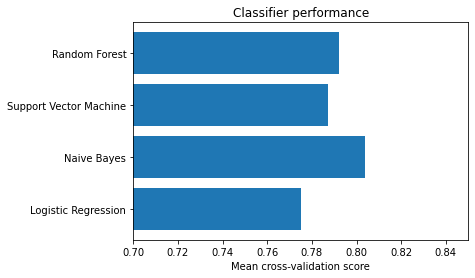

In [6]:
import matplotlib.pyplot as plt


# define the classifier names and cross-validation results
classifiers = ['Logistic Regression', 'Naive Bayes', 'Support Vector Machine', 'Random Forest']
cv_results = [0.775, 0.804, 0.787, 0.792]

# plot scores for Cross validation
fig, ax = plt.subplots()
ax.barh(classifiers, cv_results, align='center')
ax.set_xlim(0.7, 0.85)
ax.set_xlabel('Mean cross-validation score')
ax.set_title('Classifier performance')
plt.show()

### Best Model Selection

In [7]:
# select the best model
best_model = MultinomialNB()
best_model.fit(X_train, y_train)

# use the best model to predict the sentiment of a new sentence
new_sentence = "This movie was really great!"
new_sentence = preprocess_text(new_sentence)
new_sentence_feature = vectorizer.transform([new_sentence]).toarray()
sentiment = best_model.predict(new_sentence_feature)[0]
print(f"Predicted sentiment: {sentiment}")

Predicted sentiment: 1


In [8]:
# select the best model
best_model = MultinomialNB()
best_model.fit(X_train, y_train)

# use the best model to predict the sentiment of a new sentence
new_sentence = "It always cuts out and makes a beep beep beep sound then says signal faild"
new_sentence = preprocess_text(new_sentence)
new_sentence_feature = vectorizer.transform([new_sentence]).toarray()
sentiment = best_model.predict(new_sentence_feature)[0]
print(f"Predicted sentiment: {sentiment}")

Predicted sentiment: 0


#### Show representative examples of false positives and false negatives

In [9]:
#convert y-pred-test to dataframe
y_pred_test = pd.DataFrame(y_pred_test, columns=['Prediction'])
y_pred_test

# add column names
test_data.columns = ['Source', 'Reviews', 'Sentiment']

# concatenate the X_train DataFrame with the y_train_pred DataFrame
Comparison_data = pd.concat([test_data, y_pred_test], axis=1)
Comparison_data

# identify false positives and false negatives
false_positives = Comparison_data[(Comparison_data['Sentiment']==0) & (Comparison_data['Prediction']==1)]
false_positives
false_negatives = Comparison_data[(Comparison_data['Sentiment']==1) & (Comparison_data['Prediction']==0)]
false_negatives

,Source,Reviews,Sentiment,Prediction
102,amazon,W810i is just SUPERB.,1,0
104,amazon,Cheap but hey it works.. Was pleasantly supris...,1,0
108,amazon,"No shifting, no bubbling, no peeling, not even...",1,0
111,amazon,The delivery was on time.,1,0
113,amazon,The eargels channel the sound directly into yo...,1,0
...,...,...,...,...
586,yelp,The pizza selections are good.,1,0
589,yelp,These are the nicest restaurant owners I've ev...,1,0
590,yelp,First time going but I think I will quickly be...,1,0
591,yelp,My boyfriend and i sat at the bar and had a co...,1,0


#### Does it do better on longer sentences or shorter sentences?

In [10]:
# count the number of words in each cell of the 'text' column
Comparison_data['num_words'] = Comparison_data['Reviews'].apply(lambda x: len(x.split()))

# group the data by the condition "if the prediction matches the sentiment (label)"
grouped = Comparison_data.groupby(Comparison_data['Sentiment'] == Comparison_data['Prediction'])

# calculate the average number of words in the reviews for each group
avg_num_words = grouped['num_words'].mean()

# print the results
print(avg_num_words)

False    12.227941
True     11.549569
Name: num_words, dtype: float64


#### Does it do better on a particular kind of review (amazon or imdb)?

In [11]:
correct_pred_source = Comparison_data[Comparison_data['Prediction'] == Comparison_data['Sentiment']].groupby('Source').sum()['Prediction']
correct_pred_source

Source
amazon    75
imdb      59
yelp      66
Name: Prediction, dtype: int64

#### Does it do better on sentences without negation words ("not", "didn't", "shouldn't", etc.)?

In [12]:
# Define a function to check if a sentence contains negation words
def has_negation(sentence):
    negation_words = ['not', 'never', 'didn\'t', 'couldn\'t', 'wouldn\'t', 'shouldn\'t', 'don\'t', 'won\'t']
    for word in negation_words:
        if word in sentence:
            return True
    return False

# Create a new column to indicate if each sentence has negation words or not
Comparison_data['has_negation'] = Comparison_data['Reviews'].apply(has_negation)

correct_pred_negation = Comparison_data[Comparison_data['Prediction'] == Comparison_data['Sentiment']].groupby('has_negation').sum()['Prediction']
correct_pred_negation

has_negation
False    184
True      16
Name: Prediction, dtype: int64